<a href="https://colab.research.google.com/github/bozorgpanah/WASP-Software-Engineering-Project/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow --upgrade
!pip install pytest
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

2.4.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:566.7543,  mae:22.5271,  mse:566.7543,  val_loss:558.3337,  val_mae:22.2995,  val_mse:558.3337,  
....................................................................................................
Epoch: 100, loss:6.1749,  mae:1.7421,  mse:6.1749,  val_loss:8.1658,  val_mae:2.1776,  val_mse:8.1658,  
..........................................................

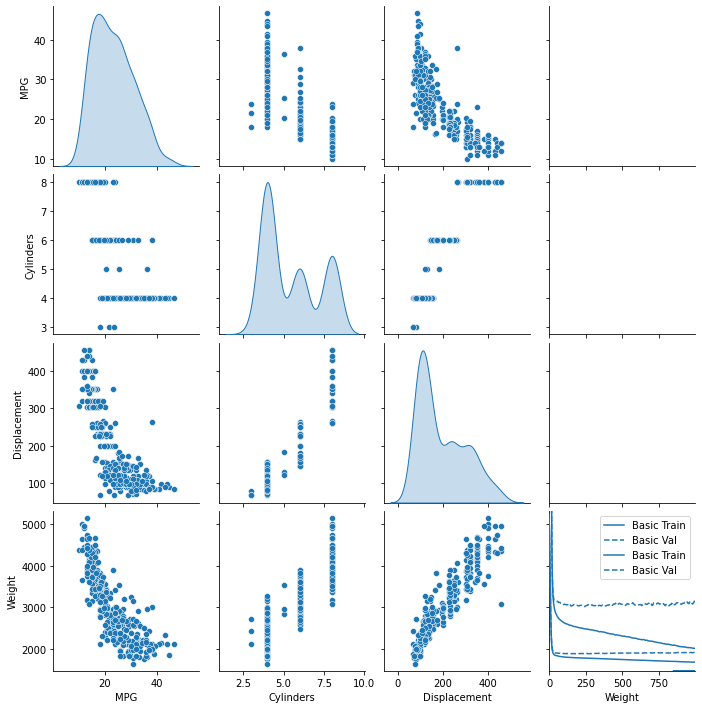


Epoch: 0, loss:569.1132,  mae:22.6801,  mse:569.1132,  val_loss:560.0672,  val_mae:22.4910,  val_mse:560.0672,  
.........................................................3/3 - 0s - loss: 6.1320 - mae: 1.8778 - mse: 6.1320
Testing set Mean Abs Error:  1.88 MPG
Testing set MSE:  6.13 MPG
Testing set Loss:  6.13 MPG


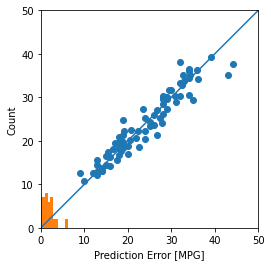

In [2]:
#Regression>>>predict the output of a continuous value
#Dataset>>>classic Auto MPG 

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import unittest
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

#Downloading the dataset
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

#Importing the data using Pandas library
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

#Cleanin the data
dataset.isna().sum()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

#Spliting the data into train and test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde") #Graph
#overall statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

#Splitting features from labels
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
#Normalizing the data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#Building the model
def build_model():
  model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), layers.Dense(64, activation='relu'), layers.Dense(1)])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

model = build_model()

#Inspecting the model
model.summary()
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

#Training the model
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, 
                    verbose=0, callbacks=[tfdocs.modeling.EpochDots()])
hist = pd.DataFrame(history.history)
print(hist, end='\n')
hist['epoch'] = history.epoch
hist.tail()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')
plt.show()

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set MSE: {:5.2f} MPG".format(mse))
print("Testing set Loss: {:5.2f} MPG".format(loss))

#Making prediction
test_predictions = model.predict(normed_test_data).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
x_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
x_ = plt.ylabel("Count")
 

In [3]:
##########################################Test Part##########################################
import unittest
from test import support

class Test(unittest.TestCase):
  def test_Mean_Abs_Error(self):
    min_error = 1.5
    max_error = 2
    assert min_error <= mae <= max_error
    
  def test_MSE(self):
    self.assertIsNotNone(mse)
    
  def test_loss_mse(self):
    try: 
     assert mse == loss   
    except AssertionError:
     print("mse: %f" %mse , " and loss: %f" %loss, " are not exactly equal!")

  def test_epochs(self):
    expected = 1000
    message = "There is an Error, the actual and ecpected values are not equal!"
    self.assertEqual(EPOCHS,expected,message) #assert actual_hist == expected
 
  def test_prediction(self): 
    min_p = 7
    max_p = 41
    try: 
      assert min_p <= test_predictions.all() <= max_p
    except AssertionError:
     print(" ")

suite = unittest.TestLoader().loadTestsFromTestCase(Test)
unittest.TextTestRunner().run(suite)

.....


----------------------------------------------------------------------
Ran 5 tests in 0.008s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>